In [1]:
# TODO:

# - Investigar umbral para las responsibilities
# - Eficiencia RDD vs DF para recalcular parámetros
# - Producto matricial en M-step para D > 1
# - MLlib vs ML for linear regression

In [2]:
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.special import logsumexp # previously from scipy.misc import logsumexp
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
sb.set()

from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, VectorUDT
from pyspark.sql.functions import udf, mean as _mean, element_at, col, lit
from pyspark.sql.types import *

#Clase componente para facilitar la manipulación del modelo
class Component:

    def __init__(self, pi, mu, sigma, w0, w, betaInv):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma
        self.w0 = w0
        self.w = w
        self.betaInv = betaInv

In [3]:
# Block with the util functions (utils.py)

def _computeResp(features, target, components):
      
        logPdfCompList = list()

        for component in components:
          
            pi = component.pi
            mu = component.mu
            sigma = component.sigma
            w = component.w
            w0 = component.w0
            betaInv = component.betaInv

            logPdfComp = (np.log(pi) + 
                          multivariate_normal.logpdf(features, mean=mu, cov=sigma) + 
                          norm.logpdf(target, loc=w0+np.dot(w,features), scale=np.sqrt(betaInv)))

            logPdfCompList.append(logPdfComp)

        logPdfComp = np.array(logPdfCompList)

        logPdf = logsumexp(logPdfComp)
        resp = np.exp(logPdfComp - logPdf)

        # TODO: probar si este bloque afecta. Normalizar L1??
        resp = resp * (resp > 1e-10)
        resp = resp / sum(resp)
        
        results = np.insert(resp, 0, logPdf)

        return Vectors.dense(results)
    
def _computeRespTest(features, target, components):
      
        logPdfCompList = list()

        for component in components:
          
            pi = component.pi
            mu = component.mu
            sigma = component.sigma

            logPdfComp = (np.log(pi) + 
                          multivariate_normal.logpdf(features, mean=mu, cov=sigma))

            logPdfCompList.append(logPdfComp)

        logPdfComp = np.array(logPdfCompList)

        logPdf = logsumexp(logPdfComp)
        resp = np.exp(logPdfComp - logPdf)

        # TODO: probar si este bloque afecta. Normalizar L1??
        resp = resp * (resp > 1e-10)
        resp = resp / sum(resp)

        return Vectors.dense(resp)
      
# UDFs block
pdfUdf = udf(lambda x: float(x[0]),  FloatType())
respUdf = udf(lambda x: Vectors.dense(x[1:]),  VectorUDT())
vect2arrayUdf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

def selectRespCol(df,i,col):
    
    # UDF to compute the product between a vector and a scalar or two scalars
    selColUdf = udf(lambda w: w[i], DoubleType())
    
    # Create the tmp column
    df = df.withColumn('tmp', selColUdf(col))
    
    return df

In [4]:
class ClusterwiseLinearModel:
  
    def __init__(self, K, nDatos):
      
        self.path2data = None # With a normal dataset, change this
        self.components = None
        self.dataTr = None
        self.dataVal = None
        self.dataTst = None
        self.dim = None
        self.K = K
        self.logLikelihoodEvol = list()
        self.nWorkers = None
        self.nTrPoints = None
        self.datasetSize = nDatos
        
        return
      
    def loadData(self):
      
        # In this case, no file with the data. We would have something like:
        #data = loadmat(path2data)['data_mat']

        # For this case with an artificial dataset
        nPoints = self.datasetSize
        
        betaInvTrue = 1
        X = np.random.uniform(-15,15,nPoints)[:,np.newaxis]
        Y = (10 / (1 + np.exp(X)) + np.random.normal(0,np.sqrt(betaInvTrue),(nPoints,1)))
        # A partir de aquí, compartido ##########################################################
        
        # Añadimos los IDs
        ids = np.arange(nPoints)[:,np.newaxis]

        # Paralelización de los datos (sólo train)
        data = np.hstack([ids,X,Y]).astype(float)
        dataRDD = sc.parallelize(data, 800)
        
        # Get the dimensionality of the dataset
        self.dim = X.shape[1]

        dataDF = (dataRDD.map(lambda x: x.tolist()).toDF()
                         .withColumnRenamed('_1', 'ID')
                         .withColumnRenamed('_'+str(self.dim+2), 'target'))
        
        # Get all the columns to generate a unique feature column
        colNames = list(range(2, self.dim+2))
        colNames = ['_' + str(col) for col in colNames]

        # Generate the features column
        vectorAssembler = VectorAssembler(inputCols = colNames, outputCol = 'features')
        dataDF = vectorAssembler.transform(dataDF)
        dataDF = dataDF.select(['ID', 'features', 'target'])
        
        # Train-Val-Test split
        #[dataTrDF, dataValDF, dataTstDF] = dataDF.randomSplit([0.98,0.01,0.01])

        self.dataTr = dataDF
        self.dataVal = None # |
        self.dataTst = None # |--> Once we have the model, we don't need to parallelize to predict!!
        
        return
    
    def initModelRandom(self):
        
        print('-- Initializing the model')
        
        # Init the empty components
        compList = list()
        
        # Cluster proportions
        piArray = (1/self.K) * np.ones(self.K) #np.random.dirichlet(5*np.ones(self.K),1)[0]
        
        # GMM parameters
        muArray = np.random.uniform(-10,10,(self.dim,self.K))
        sigmaArray = np.eye(self.dim)
        
        # LR parameters
        wArray = np.random.uniform(-2,2,(self.dim,self.K))
        w0Array = np.random.uniform(0,10,self.K)
        
        for i in range(self.K):
            
            # Component parameters
            pi = piArray[i]
            mu = muArray[:,i]
            sigma = sigmaArray
            w = wArray[:,i]
            w0 = w0Array[i]
            betaInv = 1
            
            # Append component
            compList.append(Component(pi, mu, sigma, w0, w, betaInv))

        self.components = compList
        
        # Get the number of workers and training points
        self.nWorkers = self.dataTr.rdd.getNumPartitions()
        self.nTrPoints = self.dataTr.count()
        
        print('   |--> Model initialized at random')
        
        return
        
    def E_step(self):
          
        print('-- E step')    
            
        df = self.dataTr.drop('resp', 'logPDF')
        components = self.components
        
        print('   |--> Computing responsibilities')
        
        # We have to redefine the UDF in each iteration so the components are updated
        computeRespUdf = udf(lambda features, target: _computeResp(features, target, components),  VectorUDT())
        
        df = df.withColumn('resp', computeRespUdf(df['features'], df['target']))
        
        df = df.withColumn('logPDF', pdfUdf(df['resp']))
        df = df.withColumn('resp', respUdf(df['resp']))
        
        dfStats = df.select(
            _mean(df['logPDF']).alias('loglikelihood'),
        ).collect()

        loglikelihood = dfStats[0]['loglikelihood']
        
        self.logLikelihoodEvol.append(loglikelihood)
        
        # Drop the unwanted columns
        df = df.drop('logPDF')
        df = df.withColumn('resp',vect2arrayUdf('resp'))
        
        self.dataTr = df
        
        return
      
    def M_step(self):
        
        print('-- M step')
        print('   |--> Updating model parameters')
    
        df = self.dataTr
      
        Nk = (df.select('resp')
                .rdd
                .map(lambda x: np.array(x))
                .reduce(lambda x,y: x+y)
             )[0]
        
        print(Nk)

        
        piNew = Nk / sum(Nk)
        
        muNew = list()
        sigmaNew = list()
        w0New = list()
        wNew = list()
        betaInvNew = list()
        
        # To save the indices of the collapsed components
        collapsedComps = list()
        
        for i in range(self.K):
            
            if piNew[i] > 0.3 / self.K:
            
                df = df.withColumn('tmp',element_at(df['resp'], i+1))

                mu = (df.select('features', 'tmp')
                        .rdd
                        .map(lambda x: x[1] * x[0])
                        .reduce(lambda x,y: x+y)
                     ) / Nk[i]


                sigma = (df.select('features', 'tmp')
                           .rdd
                           .map(lambda x: np.array(x[1]) * np.square(x[0] - mu))
                           .reduce(lambda x,y: x+y)
                        )[0] / Nk[i]


                lr = (LinearRegression().setMaxIter(20)
                                        .setRegParam(0.1)
                                        .setElasticNetParam(0)
                                        .setFeaturesCol('features')
                                        .setLabelCol('target')
                                        .setWeightCol('tmp'))

                modelLr = lr.fit(df)

                w0 = modelLr.intercept
                w = modelLr.coefficients
                betaInv = np.sqrt(modelLr.summary.meanSquaredError)

                muNew.append(mu)
                sigmaNew.append(sigma)
                w0New.append(w0)
                wNew.append(w)
                betaInvNew.append(betaInv)
            
            else:
                print(f'   |--> Component {i} collapsed. Deleting it')
                collapsedComps.append(i)
                
        self.K -= len(collapsedComps)
        piNew = np.delete(piNew, collapsedComps)
        
        print(self.K,piNew)
        
        # Update components
        compsNew = list()
        
        for i in range(self.K):
        
            compsNew.append(Component(piNew[i], muNew[i], sigmaNew[i], w0New[i], wNew[i], betaInvNew[i]))

        self.components = compsNew
        
        return
    
    def fit(self, tol, maxIter):
        
        nIter = 0
        
        for i in range(maxIter):
            if len(self.logLikelihoodEvol) > 1 and (self.logLikelihoodEvol[-1] - self.logLikelihoodEvol[-2]) < tol:
                break
            self.E_step()
            self.M_step()
            
            nIter += 1
            
        return nIter
      
    def plotComponents(self):
      
        color = ['r-','g-','b-','k-']
    
        x_axis = np.linspace(-15,15,5)

        fig = plt.figure()
        
        x = self.dataTr.rdd.map(lambda r: r[1]).collect()
        y = self.dataTr.rdd.map(lambda r: r[2]).collect()
        #c = self.dataTr.rdd.map(lambda r: np.power(r[3],2)).collect()
        
        #for i in range(len(x)):
        #    plt.plot(x[i], y[i], '.', color=c[i])
        plt.plot(x, y, '.')

        for i in range(self.K):

            regr = self.components[i].w0 + self.components[i].w * x_axis      
            plt.plot(x_axis,regr, color[0])

        plt.xlabel('features')
        plt.ylabel('target')    

        axes = plt.gca()
        axes.set_ylim([-3,13])
        
        return
        
    def plotLogLikelihood(self, initIter=0):
      
        llevol = self.logLikelihoodEvol
        nIter = list(range(1,len(llevol)+1))
        
        fig = plt.figure()
        plt.plot(nIter[initIter:],llevol[initIter:])
        
        plt.xlabel('# of iterations')
        plt.ylabel('Log-likelihood')
        
        return
      
    def printComponents(self):
        
        print('-------------------------------------')
        print()
        
        i = 0
        for component in self.components:
  
            print(f'* Component #{i}:')
            print('  |--> pi: ', component.pi)
            print('  |--> mu: ', component.mu)
            print('  |--> sigma: ', component.sigma)
            print('  |--> w0: ', component.w0)
            print('  |--> w: ', component.w)
            print('  |--> betaInv: ', component.betaInv)
            
            i += 1
            
        print()
        
    def predict(self):
        
        # Read the data
        df = self.dataTr
        components = self.components
        
        # We have to redefine the UDF in each iteration so the components are updated
        computeRespUdf = udf(lambda features, target: _computeRespTest(features, target, components),  VectorUDT())
        
        # Compute the responsibilities for the unobserved data
        df = df.withColumn('respTest', computeRespUdf(df['features'], df['target']))

        # Create and empty 'pred' column to save the predictions
        df = df.withColumn('pred', lit(0))
        
        for i in range(self.K):

            comp = self.components[i]
            w = comp.w
            w0 = comp.w0

            df = selectRespCol(df,i,'respTest')
            
        
        return df
    
    
        
    def predictPandas(self):
        
        df = self.dataTr
        components = self.components
        
        # We have to redefine the UDF in each iteration so the components are updated
        computeRespUdf = udf(lambda features, target: _computeRespTest(features, target, components),  VectorUDT())
        
        df = df.withColumn('respTest', computeRespUdf(df['features'], df['target']))
        
        # Read the data and the components
        df = df.toPandas()
        df['pred'] = np.zeros(len(df))

        for i in range(self.K):

            comp = self.components[i]
            w = comp.w
            w0 = comp.w0

            df['tmp'] = df['respTest'].apply(lambda x: x[i])
            df['pred'] += df['tmp'] * df['features'].apply(lambda x: w0 + np.dot(x,w))
        
        return df

-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[4.80097825e-07 5.98992660e-02 1.29662574e+02 7.06400274e+02
 1.63877252e+02]
   |--> Component 0 collapsed. Deleting it
   |--> Component 1 collapsed. Deleting it
3 [0.12966257 0.70640027 0.16387725]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[128.5256331  672.58480657 198.88956006]
3 [0.12852563 0.67258481 0.19888956]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[143.71677507 625.65550529 230.62771998]
3 [0.14371678 0.62565551 0.23062772]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[159.82373966 587.38921994 252.78704041]
3 [0.15982374 0.58738922 0.25278704]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[177.60137539 554.05095704 268.34766764]
3 [0.17760138 0.5

4 [0.07909579 0.47336662 0.14744445 0.30009314]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 83.72981308 464.95569354 145.30884845 306.00564537]
4 [0.08372981 0.46495569 0.14530885 0.30600565]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 92.60481479 453.30782907 142.7500702  311.33728583]
4 [0.09260481 0.45330783 0.14275007 0.31133729]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[105.67588339 439.45570073 139.88148213 314.986934  ]
4 [0.10567588 0.4394557  0.13988148 0.31498693]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[120.47509542 425.74194169 136.55784737 317.22511548]
4 [0.1204751  0.42574194 0.13655785 0.31722512]
-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[643.79862803 219.1801533   25.036720

[1003.41968779 1454.78941741  541.79089688]
3 [0.33447323 0.48492981 0.18059697]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 962.31072103 1453.80113294  583.88814832]
3 [0.32077024 0.48460038 0.19462938]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 915.10511114 1451.72052071  633.17437034]
3 [0.30503504 0.48390684 0.21105812]
-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 122.02907951 1269.71213094   81.90157758  303.47770132 1222.87951148]
   |--> Component 0 collapsed. Deleting it
   |--> Component 2 collapsed. Deleting it
3 [0.42323738 0.10115923 0.4076265 ]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[1354.39766518  326.26539093 1319.33694557]
3 [0.45146589 0.10875513 0.43977898]
-- E step
   |--> Computing responsibilities
-- M step
   |--> 

-- M step
   |--> Updating model parameters
[1194.36588555  398.03696654  975.34465169  432.25249697]
4 [0.39812196 0.13267899 0.32511488 0.14408417]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[1207.16226581  413.65829899  983.96169416  395.21773958]
4 [0.40238742 0.1378861  0.32798723 0.13173925]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[1214.79125576  438.69583392  991.0581504   355.45475998]
4 [0.40493042 0.14623194 0.33035272 0.11848492]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[1218.45386933  458.63295373 1004.28543529  318.62774282]
4 [0.40615129 0.15287765 0.33476181 0.10620925]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[1218.15500748  469.39271725 1017.74165936  294.71061613]
4 [0.40605167 0.15646424 0.33924722 0.09823687]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updatin

<ipython-input-4-a64052502df7>:244: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[3.23743718e+03 2.66077668e+03 1.21269542e+02 3.98051660e+03
 1.50616205e-06]
   |--> Component 2 collapsed. Deleting it
   |--> Component 4 collapsed. Deleting it
3 [0.32374372 0.26607767 0.39805166]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[3046.32756471 2796.29994295 4157.37249233]
3 [0.30463276 0.27962999 0.41573725]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[2547.21105245 3103.11012958 4349.67881604]
3 [0.25472111 0.31031101 0.43496788]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[2097.01703319 3413.1483885  4489.83458181]
3 [0.2097017  0.34131484 0.44898346]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[1775.19802506 3652.31585776 4572.48611724]
3 [0.

-- M step
   |--> Updating model parameters
[ 877.61038915 3662.63235559 1429.64070413 4030.11655252]
4 [0.08776104 0.36626324 0.14296407 0.40301166]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 936.06746309 3715.17339133 1342.03029054 4006.72885744]
4 [0.09360675 0.37151734 0.13420303 0.40067289]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 979.80586809 3737.42997154 1295.00234466 3987.76181746]
4 [0.09798059 0.373743   0.12950023 0.39877618]
-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[   0.         5870.30852526 2914.42422659  756.57430283  458.69294728]
   |--> Component 0 collapsed. Deleting it
   |--> Component 4 collapsed. Deleting it
3 [0.58703085 0.29144242 0.07565743]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[5811.28215659 3185.73207

-- M step
   |--> Updating model parameters
[14038.37627105 15961.62373061]
2 [0.46794588 0.53205412]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[14424.57080184 15575.4292291 ]
2 [0.48081903 0.51918097]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[14629.09834414 15370.90168081]
2 [0.48763661 0.51236339]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[14738.89467946 15261.10534052]
2 [0.49129649 0.50870351]
-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[5.43766198e-02 1.19538970e+04 1.35462583e+02 7.82551525e+03
 1.00850708e+04]
   |--> Component 0 collapsed. Deleting it
   |--> Component 2 collapsed. Deleting it
3 [0.39846323 0.26085051 0.33616903]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[12145.06844579 

3 [0.45692469 0.24852285 0.29455247]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[46351.20602088 24870.8029144  28777.99106282]
3 [0.46351206 0.24870803 0.28777991]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[46791.54789485 24822.33377634 28386.11832413]
3 [0.46791548 0.24822334 0.28386118]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[47113.3704894  24701.22058325 28185.40893755]
3 [0.4711337  0.24701221 0.28185409]
-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[1.06424296e+04 1.27225682e+04 7.50999638e+04 2.19789659e-05
 1.53503845e+03]
   |--> Component 3 collapsed. Deleting it
   |--> Component 4 collapsed. Deleting it
3 [0.1064243  0.12722568 0.75099964]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 9

3 [0.19542754 0.32030281 0.48426966]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[19448.89526964 32761.55303392 47789.55172244]
3 [0.19448895 0.32761553 0.47789552]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[19196.02473735 33617.96534972 47186.00994075]
3 [0.19196025 0.33617965 0.4718601 ]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[18874.08775125 34545.55190814 46580.36036867]
3 [0.18874088 0.34545552 0.4658036 ]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[18566.20821588 35486.86933422 45946.92247227]
3 [0.18566208 0.35486869 0.45946922]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[18342.03362447 36388.09050551 45269.87588714]
3 [0.18342034 0.3638809  0.45269876]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[18244.30

3 [0.22773833 0.1118639  0.62377932]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 73882.64248425  41731.03600365 184386.32152529]
3 [0.24627547 0.13910345 0.61462107]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 83187.46174431  46747.57885602 170064.95941239]
3 [0.27729154 0.15582526 0.5668832 ]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 91155.13653948  48669.28135087 160175.58214559]
3 [0.30385046 0.16223094 0.53391861]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 95750.35132635  49249.83440659 154999.81429323]
3 [0.31916784 0.16416611 0.51666605]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[ 97981.81179394  50014.04512503 152004.14315093]
3 [0.32660604 0.16671348 0.50668048]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model param

-- M step
   |--> Updating model parameters
[ 84125.80690854      0.         296174.01055326 474768.23627941
 144931.94657868]
   |--> Component 1 collapsed. Deleting it
4 [0.08412581 0.29617401 0.47476824 0.14493195]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[104833.20904366 310557.78138967 421099.54655414 163509.46308814]
4 [0.10483321 0.31055778 0.42109955 0.16350946]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[110197.49064973 322832.552281   404002.22124846 162967.73614512]
4 [0.11019749 0.32283255 0.40400222 0.16296774]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[110225.46734761 332039.57640646 400064.95396308 157670.00248772]
4 [0.11022547 0.33203958 0.40006495 0.15767   ]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[109450.4552693  339527.6724974  397849.50045935 153172.37197329]
4 [0.10945046 0.33

   |--> Component 3 collapsed. Deleting it
4 [0.36118355 0.47329013 0.08701573 0.06668524]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[362932.74073674 469077.45580893 104145.33705195  63844.4664866 ]
   |--> Component 3 collapsed. Deleting it
3 [0.36293274 0.46907746 0.10414534]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[416358.95305865 456759.94122024 126881.10584309]
3 [0.41635895 0.45675994 0.12688111]
-- Initializing the model
   |--> Model initialized at random
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[206549.05445967  37169.22524174 214434.17547321 285182.49958895
 256665.04554618]
   |--> Component 1 collapsed. Deleting it
4 [0.20654905 0.21443418 0.2851825  0.25666505]
-- E step
   |--> Computing responsibilities
-- M step
   |--> Updating model parameters
[219351.42548645 185003.21983127 289562.49437017 306082.86050916]
4 [0.21935143 0.18

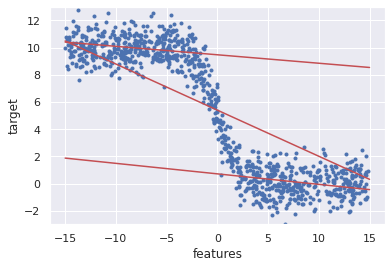

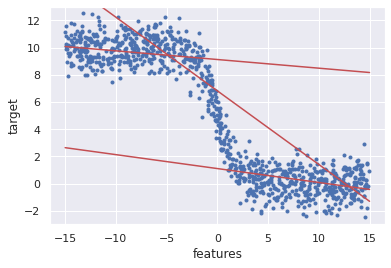

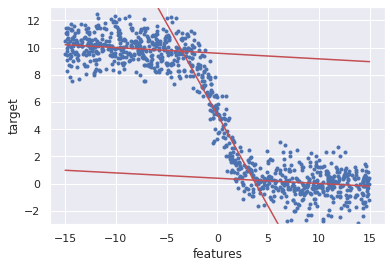

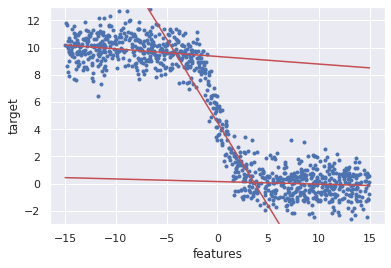

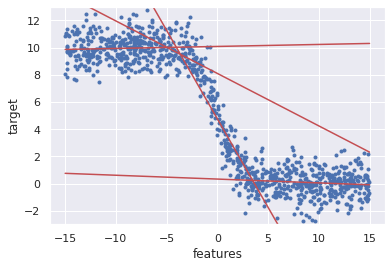

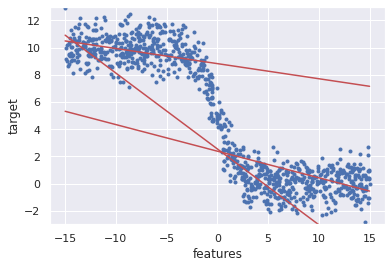

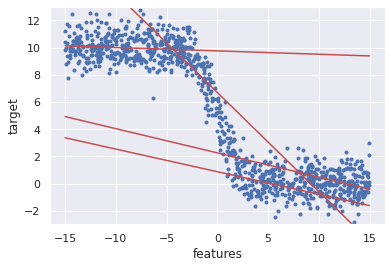

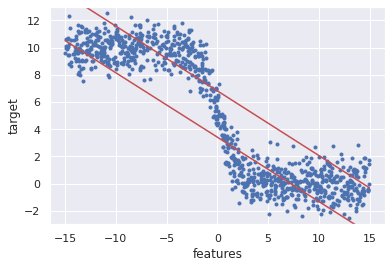

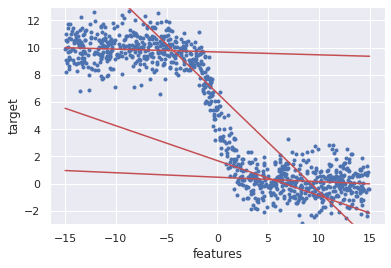

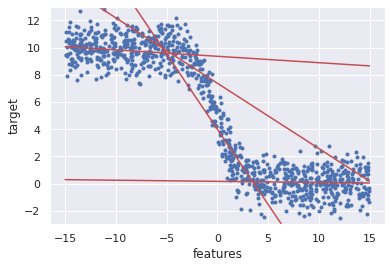

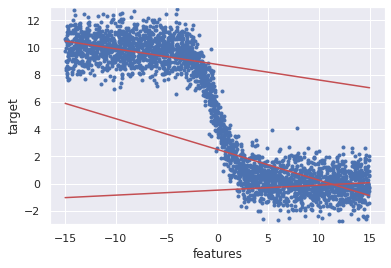

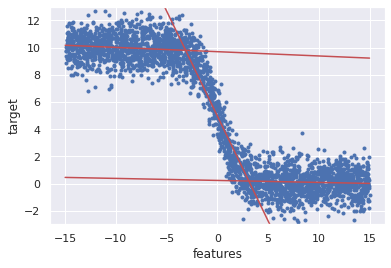

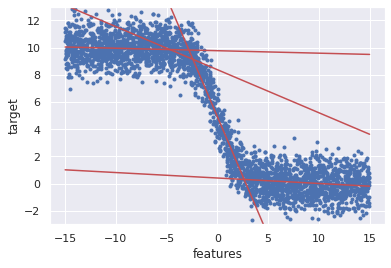

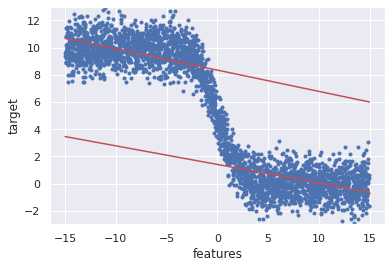

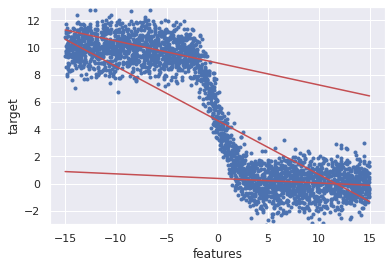

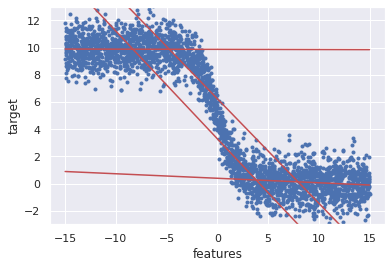

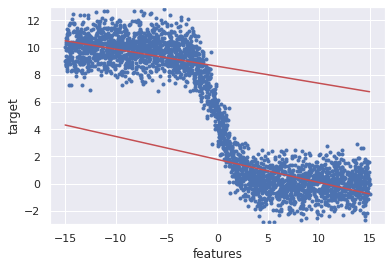

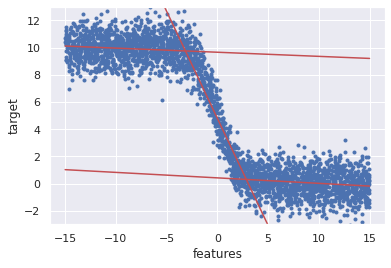

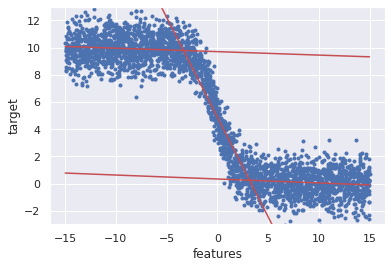

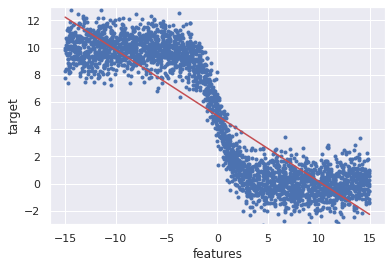

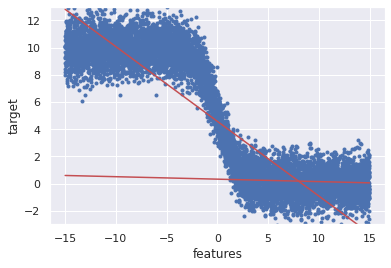

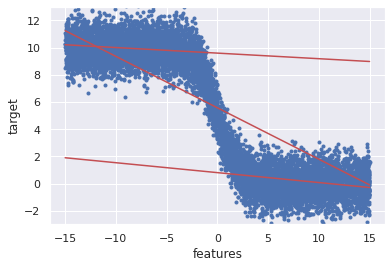

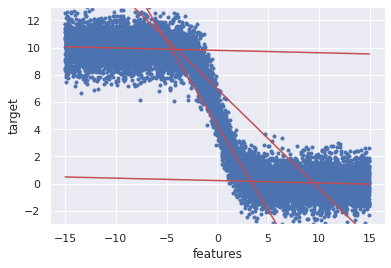

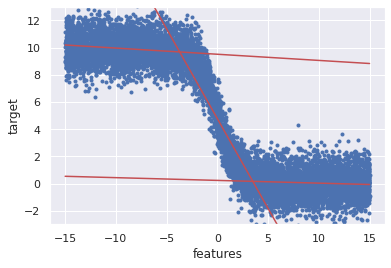

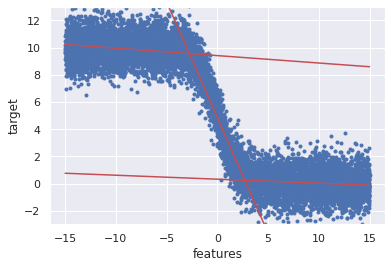

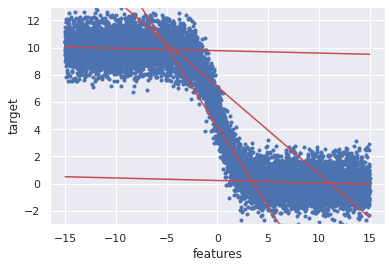

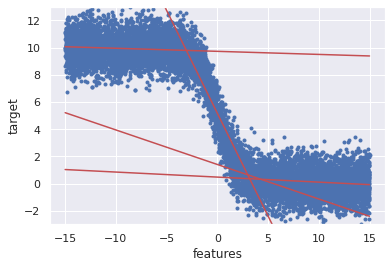

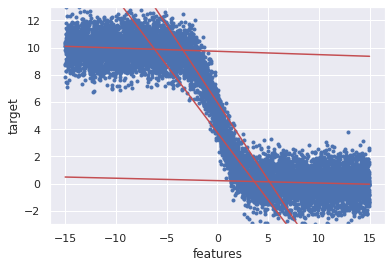

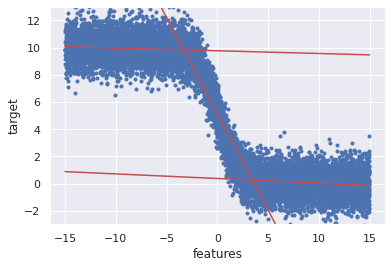

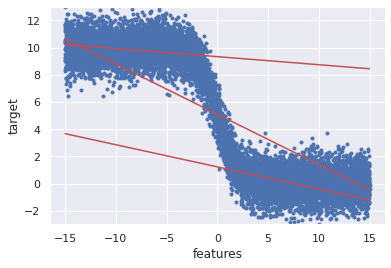

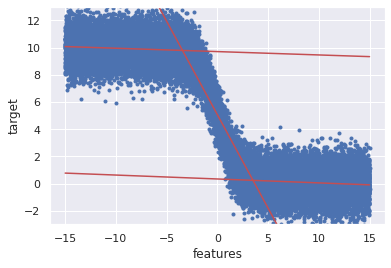

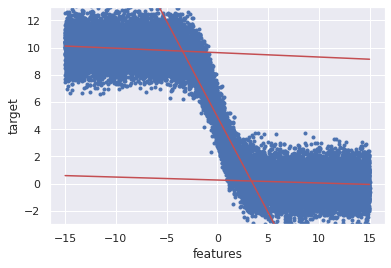

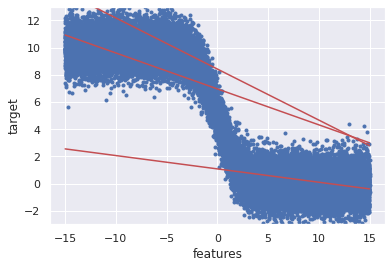

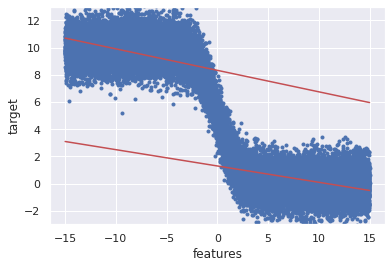

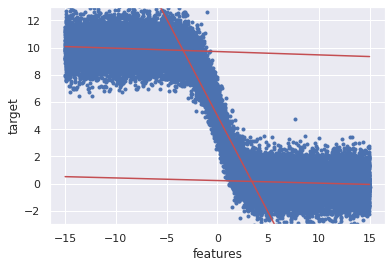

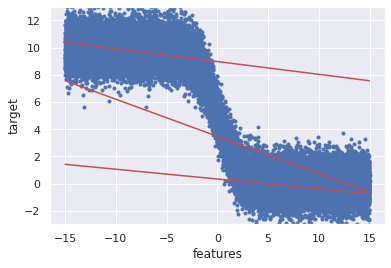

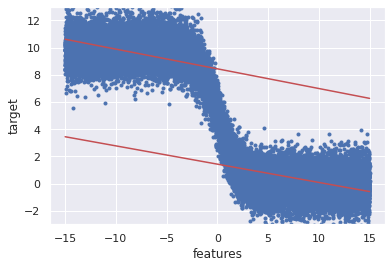

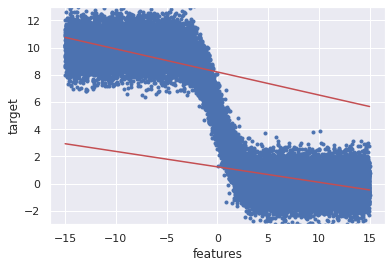

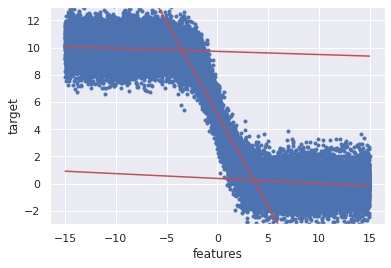

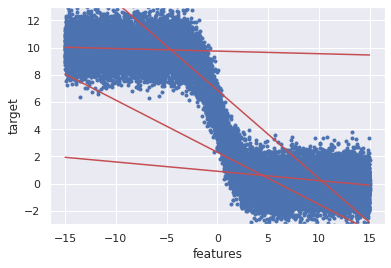

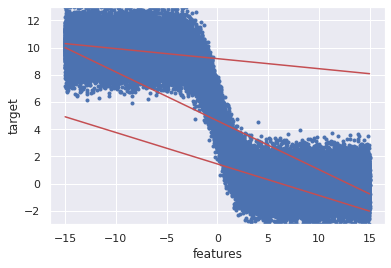

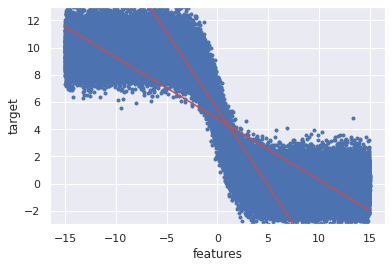

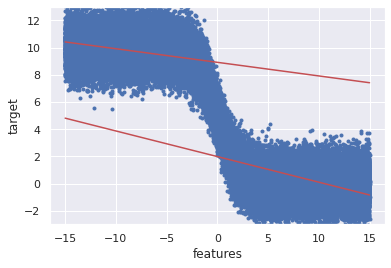

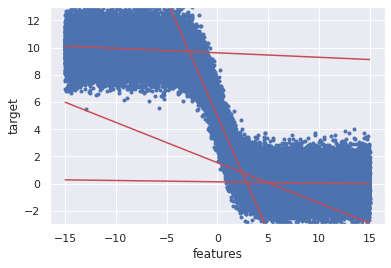

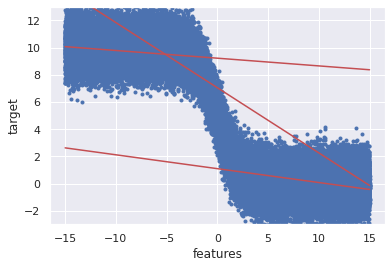

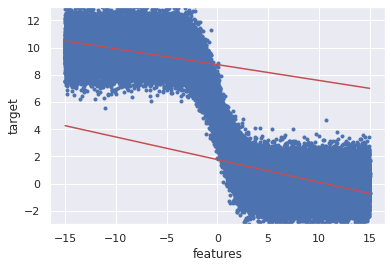

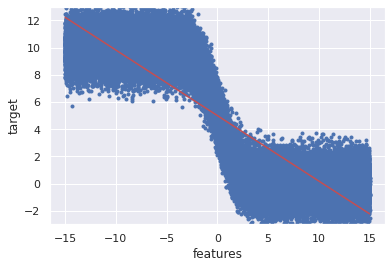

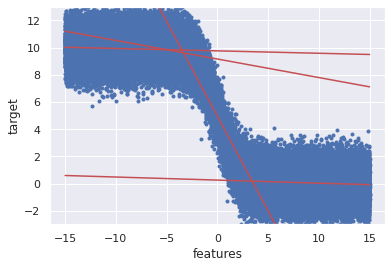

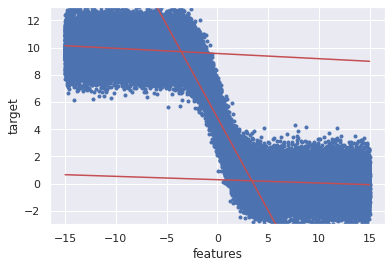

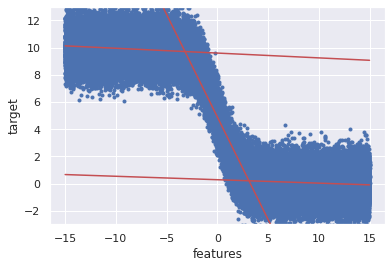

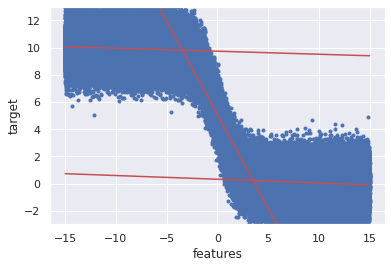

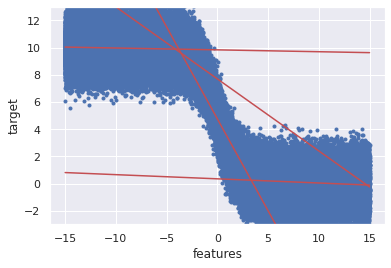

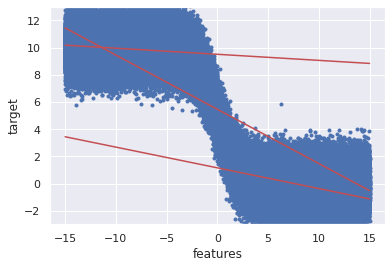

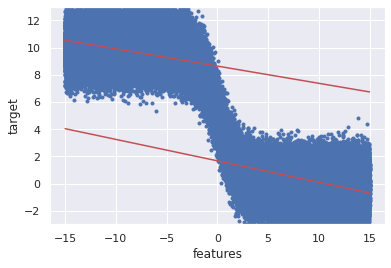

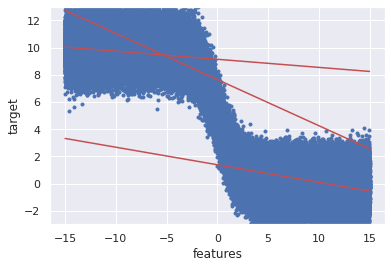

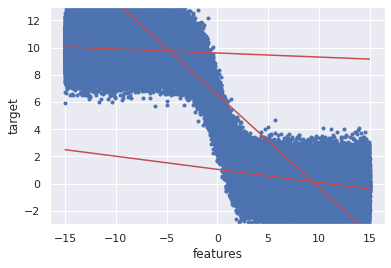

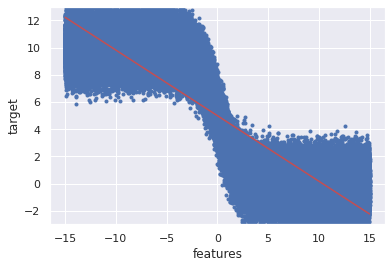

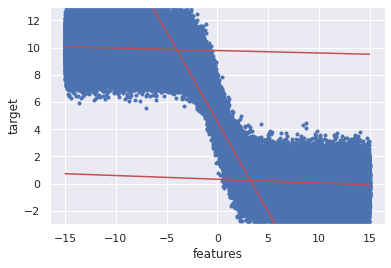

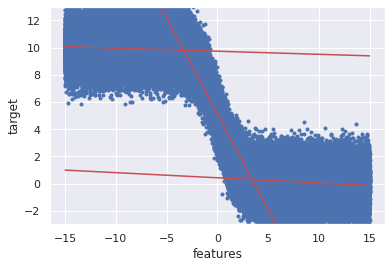

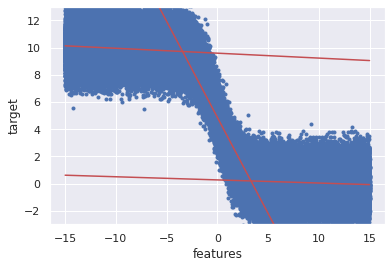

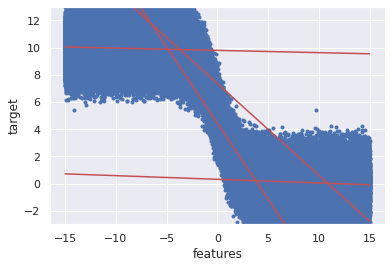

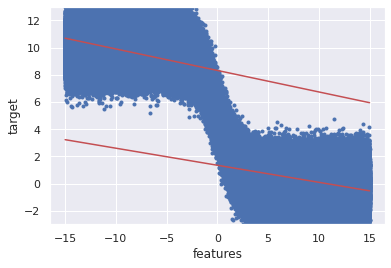

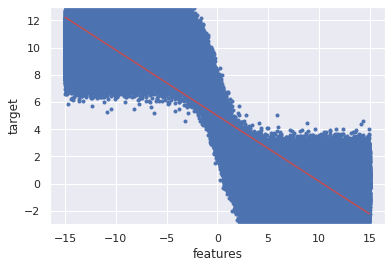

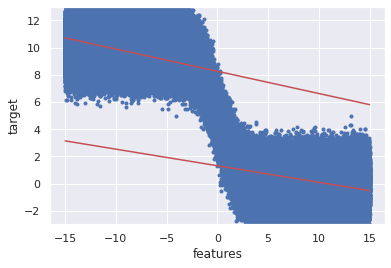

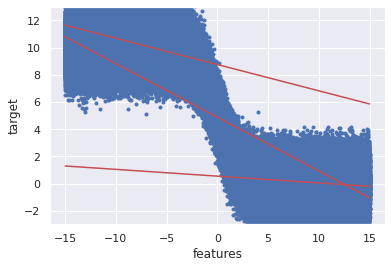

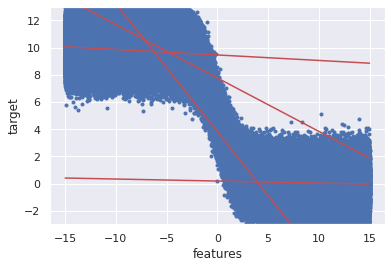

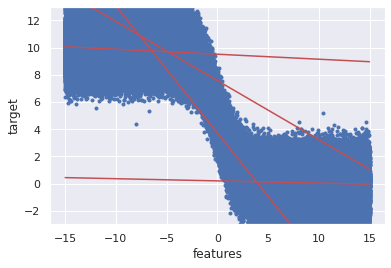

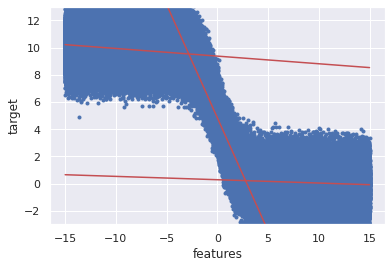

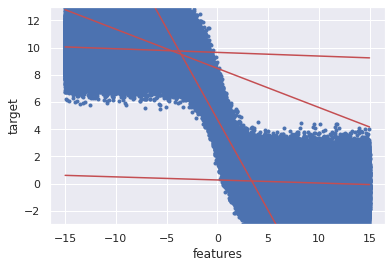

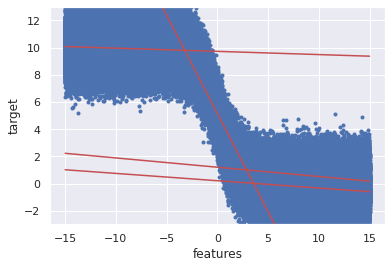

In [5]:
import time

results = list()

for nDatos in [1000,3000,10000,30000,100000,300000,1000000]:
    for run in range(10): 
    
        start = time.time()    

        mrgr = ClusterwiseLinearModel(5, nDatos)
        mrgr.loadData()
        mrgr.initModelRandom()

        nIter = mrgr.fit(1e-2,15)

        mrgr.plotComponents()
        #mrgr.plotLogLikelihood(1)

        end = time.time()
        
        results.append([nDatos,run,end-start,nIter])
        
        
    
#mrgr.predict()
    

In [6]:
df = mrgr.predictPandas()

In [7]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):  # more options can be specified also
    print(df)

          ID               features     target  \
0        0.0    [9.698320804411274]  -1.184805   
1        1.0    [3.361884120825291]   0.700453   
2        2.0  [-13.835558979223656]  10.770936   
3        3.0    [-1.84703730306504]   7.922997   
4        4.0    [7.734891265376973]  -0.040519   
...      ...                    ...        ...   
4995  4995.0   [12.295759604970513]  -0.918399   
4996  4996.0   [13.201373664960794]  -0.214154   
4997  4997.0   [12.873266839964554]   1.204630   
4998  4998.0    [7.658589885557159]  -0.550733   
4999  4999.0  [-4.1858720002773016]  11.309434   

                                                resp  \
0                                    [1.0, 0.0, 0.0]   
1       [0.3539253771305084, 0.0, 0.646074652671814]   
2                                    [0.0, 1.0, 0.0]   
3     [0.0, 0.26552173495292664, 0.7344782948493958]   
4                   [1.0, 0.0, 6.21597995298373e-10]   
...                                              ...   
4995   

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(mean_squared_error(df['target'],df['pred'],squared=False))
print(mean_absolute_error(df['target'],df['pred']))
print(r2_score(df['target'],df['pred']))

1.0344353265095723
0.8290872854867608
0.9524231121707412


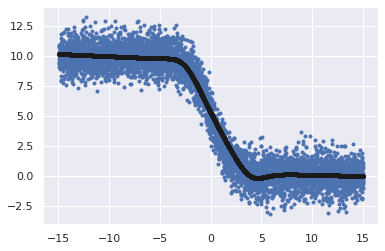

In [9]:
plt.scatter(df['features'].apply(lambda x: x[0]),df['target'],marker='.')
plt.scatter(df['features'].apply(lambda x: x[0]),df['pred'],marker='.',color='k')